# Introduction: Dogs vs Cats Classification

This notebook intends to implement a deep learning model with Convolutional Neural Networks to predict whether a given image is a dog or a cat. This is a part of the Dogs vs. Cats machine learning online competition which was hosted on kaggle. The objective of this competition is to write an algorithm to classify whether images contain a dog or a cat. In this notebook, we will implement the model using tensorflow's deep learning library - tflearn. 

This is a standard supervised classification task where the training dataset contains different images with their corresponding labels, and since the images can either be a dog or a cat, this is a binary classification problem.

## Data
The data is taken from the Dogs vs. Cats kaggle competition website:  __[Image Data](https://www.kaggle.com/c/dogs-vs-cats/data)__.

## Workflow

![image2.PNG](images/image2.PNG)

## Why not Fully Connected Network?

![image3.PNG](images/image3.PNG)

So, we need to deal with such huge amount of parameters and obviously we require more no. of neurons, which can eventually lead to overfitting. So, that is why we cannot use fully connected network for image classification.

## Why Convolution Neural Networks?

![image4.PNG](images/image4.PNG)

In case of CNN, the neuron in a layer will only be connected to a small region of the layer before it rather than all of the neurons as in fully connected manner.

### Imports

In [1]:
import pandas as pd
import numpy as np

# for enumerating on all the images in the data
import glob

# opencv library for processing images
import cv2

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf

# tensorflow's deep learning library
import tflearn
from tflearn.layers.core import input_data, fully_connected, dropout
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression

import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [ ]:
# define path of the data
path = 'C:\\kaggle\\img_data'

In [4]:
# due to the limitation of the computational resources, we will decrease the size of the images to be 50x50. 
img_size = 50
train_img_data = []
test_img_data = []
train_img_class = []
test_img_num = []
train_data = []
test_data = []
MODEL_NAME = "dogs_vs_cats"

In [ ]:
# function to extract the labels for the images from their names in the training dataset.
# Since the labels are categorical, we need to encode the labels to make them numeric.

def create_label(img_class):
    encoder = LabelEncoder()
    img_label = encoder.fit_transform(img_class)
    img_label = img_label.reshape(-1,1)
    encoder = OneHotEncoder(sparse = False)
    img_label = encoder.fit_transform(img_label)
    return img_label

### Pre-process the Data  
Due to limited computational resources, images are downsampled to 50x50 and converted to grayscale.

In [ ]:
''' fetch each image from the training dataset and process it (converting colored images to grayscale 
    and reducing the size of the image to 50x50)'''

for file in glob.glob(path + "train" + "\\" + "*.jpg"):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    train_img_data.append(np.array(img))
    train_img_class.append(file.split(".")[0].split("\\")[-1])

In [ ]:
''' fetch each image from the test dataset and process it (converting colored images to grayscale 
    and reducing the size of the image to 50x50)'''

for file in glob.glob(path + "test1" + "\\" + "*.jpg"):
    test_img_num.append(file)
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    test_img_data.append(np.array(img))

In [ ]:
# Prepare the final training dataset and shuffle it
for data,label in zip(train_img_data, create_label(train_img_class)):
    train_data.append([data, label])
shuffle(train_data)
np.save("train_data.npy", train_data)

In [ ]:
# Prepare the final test dataset and shuffle it
for data,num in zip(test_img_data, test_img_num):
    test_data.append([data, num])
shuffle(test_data)
np.save("test_data.npy", test_data)

In [ ]:
# splitting the train data into train and validation set
train = train_data[:-500]
valid = train_data[-500:]

# reshape the data for tensorflow
x_train = np.array([i[0] for i in train]).reshape(-1, img_size, img_size, 1)
y_train = np.array([i[1] for i in train])
x_test = np.array([i[0] for i in valid]).reshape(-1, img_size, img_size, 1)
y_test = np.array([i[1] for i in valid])

### Build the Model 

In [5]:
tf.reset_default_graph()

net = input_data(shape = [None, img_size, img_size, 1], name = "input")

# tflearn's convolutional layer defined with no. of filters = 32, filter size= 5x5 and activation function = relu
layer1 = conv_2d(net, 32, 5, activation="relu", name = "layer1")
# tflearn's pooling layer defined with kernel/pool size = 5x5
layer2 = max_pool_2d(layer1, 5, name="layer2")

# convolutional layer with no. of filters = 64
layer3 = conv_2d(layer2, 64, 5, activation="relu", name="layer3")

layer4 = max_pool_2d(layer3, 5, name="layer4")

# convolutional layer with no. of filters = 128
layer5 = conv_2d(layer4, 128, 5, activation="relu", name="layer5")

layer6 = max_pool_2d(layer5, 5, name="layer6")

# convolutional layer with no. of filters = 64
layer7 = conv_2d(layer6, 64, 5, activation="relu", name="layer7")

layer8 = max_pool_2d(layer7, 5, name="layer8")

# convolutional layer with no. of filters = 32
layer9 = conv_2d(layer8, 32, 5, activation="relu", name="layer9")

layer10 = max_pool_2d(layer9, 5, name="layer10")

# fully connected layer with no. of neurons = 1024 and activation function = relu
layer11 = fully_connected(layer10, 1024, activation = "relu", name="layer11")

# tflearn's dropout layer defined with keep fraction of 0.8 to randomly shoot 20% neurons in the previous layer in each 
# epoch to reduce overfitting 
layer12 = dropout(layer11, 0.8, name="layer12")

# final layer with no. of neurons = 2 correspnding to each class (dog and cat) and activation function = softmax.
layer13 = fully_connected(layer12, 2, activation = "softmax", name="layer13")

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


### Train the Model

In [6]:
# the model is trained with adam optimizer and cross entropy loss function
network = regression(layer13, optimizer='adam', loss = "categorical_crossentropy")

model = tflearn.DNN(network, tensorboard_dir = '/log/tflearn', tensorboard_verbose=3)

# due to limited computational resources, no. of training epochs are being restricted to only 10. If we increase the 
# no. of epochs, the accuracy will certainly increase. 
model.fit({'input': x_train}, y_train, n_epoch=10, shuffle=True, 
          validation_set= ({"input": x_test}, y_test), show_metric=True)

# save the trained model
model.save("dog_vs_cats.tflearn")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Predict and Plot the Test Images

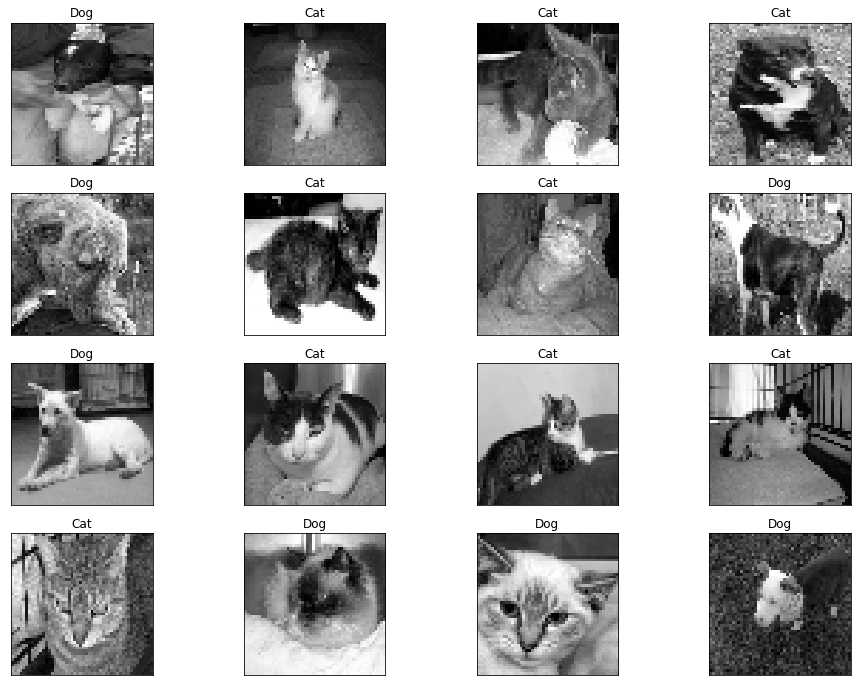

In [10]:
fig = plt.figure(figsize = (16,12))

for num, data in enumerate(test_data[:16]):

    img_data = data[0]
    img_num = data[1]

    y = fig.add_subplot(4,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]

    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'

    plt.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

The above plot shows some of the images from our test dataset and above each image, there is a label predicted by our CNN model
corresponding to that image.